In [125]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
import math
import os
from models import encoder

In [126]:
import random
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

In [127]:
print(torch.__version__)

2.0.1+cu117


In [128]:
torch.cuda.is_available()

True

In [129]:
#to get the current working directory
directory = os.getcwd()

print(directory)

/home/aandre/fmri_project


In [130]:
from models import encoder3
#load model 2
model2 = encoder3.resnet101()
model2 = model2.cuda()

path = 'pretrained/MARS_HMDB51_16f.pth'
encoder.load_weights(model2, path)

In [146]:
#add already trained if wanted
path_pretrained = 'saved_model/encoder2_bis.pth'
checkpoint = torch.load(path_pretrained)
model2.load_state_dict(checkpoint)

<All keys matched successfully>

In [132]:
input_test = torch.rand(3, 32, 112, 112)
input_test = input_test.view(-1, 3, 32, 112, 112).cuda()

In [133]:
output_test = model2(input_test)
output_test.shape

torch.Size([1, 13459])

In [99]:
import cv2
import numpy as np

class MyDataset(Dataset):
    def __init__(self, image_dir, label_dir, num_images_per_sample=32):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.num_images_per_sample = num_images_per_sample
        self.sample_ids = os.listdir(self.label_dir)
        random.shuffle(self.sample_ids)
        
    def __len__(self):
        return len(self.sample_ids)
    
    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx].replace("label","").replace(".npy","")
        image_batch = []
        for i in range(1, self.num_images_per_sample+1):
            image_name = 'frame_{:03d}_{:03d}.jpg'.format(int(sample_id), i)
            image_path = os.path.join(self.image_dir, image_name)
            im = cv2.imread(image_path)
            im = im[90:620,170:1120,:]
            im_resized = cv2.resize(im, (112, 112), interpolation=cv2.INTER_LINEAR)
            im_tensor = torch.from_numpy(im_resized)
            image_batch.append(im_tensor)
        image_batch = torch.stack(image_batch)
        label_name = 'label' + sample_id + '.npy'
        label_path = os.path.join(self.label_dir, label_name)
        label = np.load(label_path)
        return image_batch, label

image_dir = '/media/miplab-nas2/Data3/andre/stimuli_final'
label_dirs = 'labels2/1'


train_dataset = MyDataset(image_dir, label_dirs)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print(len(train_dataset))


3599


In [100]:
len(train_dataset)

3599

In [101]:
data_iter = iter(train_dataset)
x, y = next(data_iter)
x.shape

torch.Size([32, 112, 112, 3])

In [102]:
y.shape

(13459,)

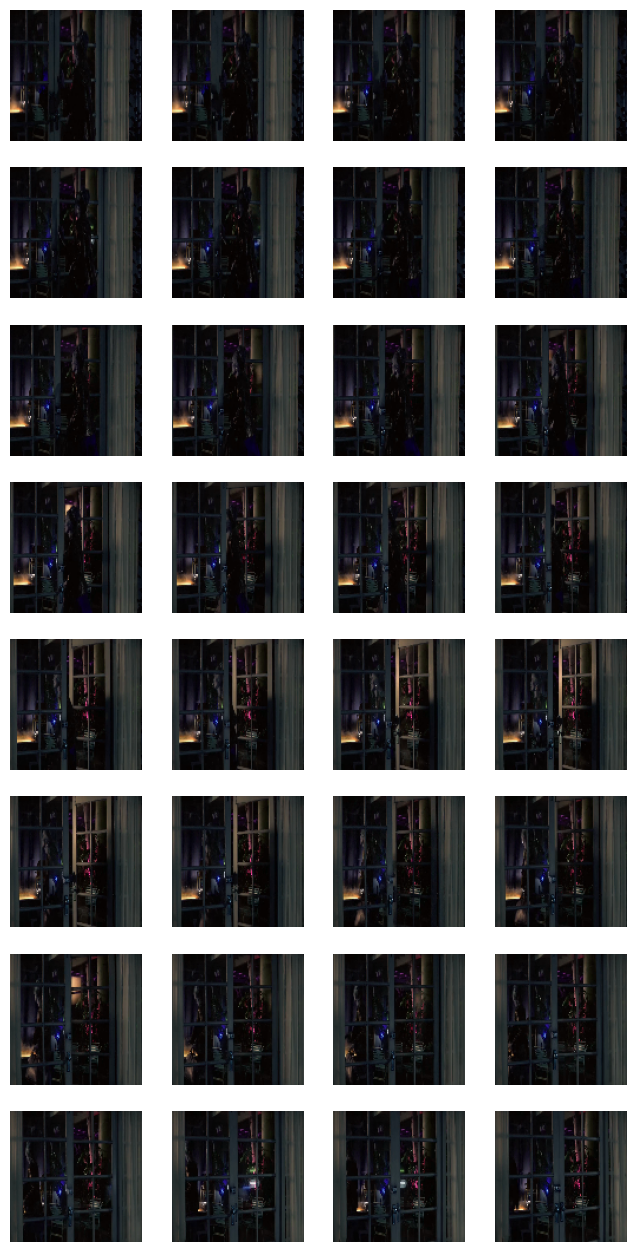

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the dimensions of x
#x = np.transpose(x, (0, 3, 1, 2))

# Plot the images
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(8, 16))
for i in range(32):
    row = i // 4  # Calculate the row index
    col = i % 4    # Calculate the column index
    axs[row, col].imshow(x[i])
    axs[row, col].axis('off')

# Show the plot
plt.show()


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
import torch.optim as optim
initial_lr = 1e-4
lr_factor = 0.2
lr_step_size = 3

def get_learning_rate(epoch):
    return initial_lr * math.pow(lr_factor, math.floor(epoch / lr_step_size))


optimizer = optim.Adam(model2.parameters(), lr=get_learning_rate(0))


In [ ]:
from losses import losses

alpha = 0.5
#optimizer = optim.Adam(model1.parameters(), lr=0.001)
num_epochs = 15
print_interval = 10
losses_tot = []
min_loss = 1000000000000 #max seen on epoch 0 and 1

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

for epoch in range(num_epochs):
    if epoch < 10:
        continue
    if epoch == 10:
        current_lr = get_learning_rate(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        print("current lr :",current_lr)
    
    for i, (images, fmri) in enumerate(iter(train_dataloader)):
        optimizer.zero_grad()
        images = images.to(device).float()
        images = images.view(-1, 3, 32, 112, 112)
        fmri = fmri.to(device).float()
        r_hat = model2(images)
        loss = losses.fmri_loss(fmri, r_hat, alpha)
        losses_tot.append(loss.mean().item())
        if (loss.mean().item()) < min_loss:
            min_loss = loss.mean().item()
            print('saving model with loss =', min_loss)
            torch.save(model2.state_dict(), 'saved_model/encoder_sub1_bis.pth')
        loss.mean().backward()
        optimizer.step()
        
        # Print training statistics
        if i % print_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_dataloader)}], Loss: {loss.mean().item():.4f}")

            # Adjust the learning rate
        current_lr = get_learning_rate(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    #scheduler.step()
    

In [18]:
np.save('saved_model/encoder_losses_sub1_2_part2.npy', np.array(losses_tot))

>TEST OUTPUT

In [171]:
from models import decoder2

dec = decoder2.Decoder2()
dec.cuda()
#add already trained
path_pretrained_dec = 'saved_model/decoder2_sub1.pth'
checkpoint = torch.load(path_pretrained_dec)
dec.load_state_dict(checkpoint)
dec.eval()


Decoder2(
  (fc_output): Linear(in_features=13459, out_features=25088, bias=True)
  (conv1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (upsample1): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (upsample2): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (upsample3): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid): Sigmoid()
  (upsample4): UpsamplingNearest2d(scale_factor=2.0, mode='

In [172]:
for param in model2.parameters():
    param.requires_grad = False

In [173]:
fmri_out = model2(x.to(device).float().view(-1, 3, 32, 112, 112))

In [174]:
for param in dec.parameters():
    param.requires_grad = False

In [175]:
test_out = dec(fmri_out)

In [176]:
test_out.shape

torch.Size([1, 3, 112, 112])

In [177]:
image_array = test_out.squeeze().permute(1, 2, 0).cpu().numpy()

In [178]:
image_array.shape

(112, 112, 3)

In [179]:
np.unique(image_array)

array([-3.1057632, -2.8984108, -2.87669  , ...,  3.0793865,  3.1153011,
        3.2449172], dtype=float32)

In [180]:
def scale_array(arr, new_min, new_max):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    
    scaled_arr = (arr - arr_min) * (new_max - new_min) / (arr_max - arr_min) + new_min
    
    return scaled_arr.astype(int)

scaled_arr = scale_array(image_array, 0, 255)

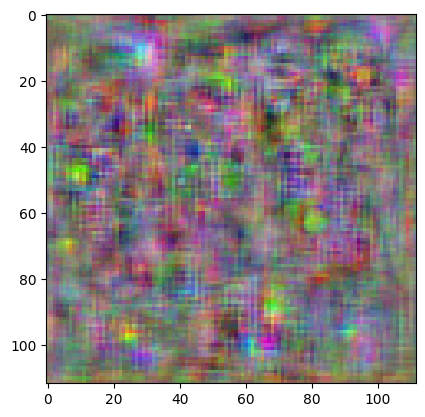

In [181]:
plt.imshow(scaled_arr)

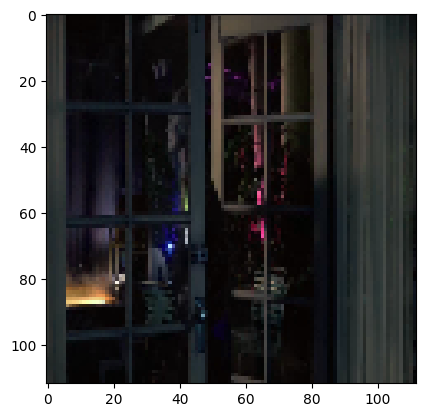

In [182]:
plt.imshow(x[16])

In [183]:
gt = x[16].squeeze().cpu().numpy()

In [184]:
import numpy as np
from scipy.stats import pearsonr

def calculate_ssim(array1, array2):
    # Calculate SSIM
    mse = np.mean((array1 - array2) ** 2)
    ssim_score = (1.0 - mse) if mse > 0 else 1.0
    return ssim_score

def calculate_pearson_coefficient(array1, array2):
    # Calculate Pearson correlation coefficient
    pearson_coefficient, _ = pearsonr(array1.flatten(), array2.flatten())
    return pearson_coefficient

# Example usage
array1 = gt
array2 = scaled_arr

ssim_score = calculate_ssim(array1, array2)
pearson_coefficient = calculate_pearson_coefficient(array1, array2)

print("SSIM:", ssim_score)
print("Pearson coefficient:", pearson_coefficient)


import numpy as np
from scipy.stats import pearsonr


SSIM: -9244.074909651361
Pearson coefficient: 0.02963567882968882
